# Power Outages Energy Consumption Statistical Analysis

**Name(s)**: Diego Osborn

**Website Link**: https://d2osborn.github.io/Power-Outages/

In [25]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.linear_model import LinearRegression, Lasso
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import datetime
import plotly.graph_objects as go

pio.renderers.default = 'notebook'
import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import *

## Step 1: Introduction and Question Identification	

Understand the data you have access to. Brainstorm a few questions that interest you about the dataset. Pick one question you plan to investigate further. (As the data science lifecycle tells us, this question may change as you work on your project.)	

Question: What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?

## Step 2: Data Cleaning and Exploratory Data Analysis

Data Cleaning

Clean the data appropriately. For instance, you may need to replace data that should be missing with NaN or create new columns out of given ones (e.g. compute distances, scale data, or get time information from time stamps).	

In [26]:
outage = pd.read_excel('outage.xlsx')
outage = outage.iloc[4:, 1:]
outage = outage.reset_index(drop=True)
outage.columns = outage.iloc[0]
outage = outage.iloc[2:, :]
outage = outage.reset_index(drop=True)

def change_to_time(date, time):
    combined = pd.to_datetime(date[date.notna()].astype(str) + ' ' + time[time.notna()].astype(str), 
                              errors='coerce')
    return combined

outage['OUTAGE.START'] = change_to_time(outage['OUTAGE.START.DATE'], outage['OUTAGE.START.TIME'])
outage['OUTAGE.RESTORATION'] = change_to_time(outage['OUTAGE.RESTORATION.DATE'], 
                                              outage['OUTAGE.RESTORATION.TIME'])

outage = outage.drop(columns=['OUTAGE.START.DATE','OUTAGE.START.TIME','OUTAGE.RESTORATION.DATE',
                              'OUTAGE.RESTORATION.TIME'])

datetime_cols = ['OUTAGE.START', 'OUTAGE.RESTORATION']

str_cols = ['U.S._STATE', 'POSTAL.CODE', 'NERC.REGION', 
            'CLIMATE.REGION', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY', 
            'CAUSE.CATEGORY.DETAIL', 'HURRICANE.NAMES']
outage[str_cols] = outage[str_cols].astype('string')

int_cols = ['OBS', 'YEAR', 'OUTAGE.DURATION', 
            'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'RES.SALES', 
            'COM.SALES', 'IND.SALES', 'TOTAL.SALES', 
            'RES.CUSTOMERS', 'COM.CUSTOMERS', 'IND.CUSTOMERS', 
            'TOTAL.CUSTOMERS', 'PC.REALGSP.STATE', 'PC.REALGSP.USA', 
            'UTIL.REALGSP', 'TOTAL.REALGSP', 'POPULATION']
outage[int_cols] = outage[int_cols].astype('Int64')

float_cols = [col for col in outage.columns if col not in str_cols and col not in int_cols 
              and col not in datetime_cols]
outage[float_cols] = outage[float_cols].astype('Float64')

outage[['OUTAGE.DURATION', 
        'DEMAND.LOSS.MW', 
        'CUSTOMERS.AFFECTED']] = outage[['OUTAGE.DURATION', 'DEMAND.LOSS.MW', 
                                         'CUSTOMERS.AFFECTED']].replace(0, np.nan)

outage = outage.applymap(lambda x: np.nan if pd.isnull(x) else x)

sunrise = datetime.time(6, 0, 0)
sunset = datetime.time(20, 0, 0)
outage['IS_DARK'] = np.where(outage['OUTAGE.START'].isnull(), np.nan, 
                             (outage['OUTAGE.START'].dt.time >= sunset) | 
                             (outage['OUTAGE.START'].dt.time <= sunrise))

outage = outage.drop(columns=['CAUSE.CATEGORY.DETAIL', 'HURRICANE.NAMES'])

outage = outage[(outage['U.S._STATE'] != 'Hawaii') & (outage['U.S._STATE'] != 'Alaska')]


Univariate Analysis

Look at the distributions of relevant columns separately by using DataFrame operations and drawing at least two relevant plots.	

In [27]:
# Distribution of Outages during Day and Night Times
dark_distribution = outage['IS_DARK'].value_counts().reset_index()
dark_distribution.columns = ['IS_DARK', 'COUNT']
fig = px.bar(dark_distribution, x='IS_DARK', y='COUNT', color='IS_DARK', 
             labels={'IS_DARK': 'Night Time', 'COUNT': 'Count'})
fig.update_layout(title='Distribution of Outages during Day and Night Times', 
                  xaxis=dict(tickmode='array', tickvals=[False, True], ticktext=['Day', 'Night']))

# Distribution of Total Sales
fig = px.histogram(outage, x='TOTAL.SALES', title='Distribution of Total Sales')


Bivariate Analysis

Look at the statistics of pairs of columns to identify possible associations. For instance, you may create scatter plots and plot conditional distributions, or box-plots. You must plot at least two such plots in your notebook. The results of your bivariate analyses will be helpful in identifying interesting hypothesis tests!	

In [28]:
# Count of Outage Events per Month
outage_count_by_month = outage.groupby('MONTH')['OUTAGE.DURATION'].count()
fig = px.bar(x=outage_count_by_month.index, y=outage_count_by_month.values,
             labels={'x': 'Month', 'y': 'Count of Outages'},
             title='Count of Outage Events per Month')
fig.update_xaxes(type='category')

# Median Outage Duration per Month
outage_count_by_month = outage.groupby('MONTH')['OUTAGE.DURATION'].median()
fig = px.bar(x=outage_count_by_month.index, y=outage_count_by_month.values,
             labels={'x': 'Month', 'y': 'Outage Duration (MEDIAN)'},
             title='Median Outage Duration per Month')
fig.update_xaxes(type='category')

# Median Outage Duration per State
outage_fig = outage.groupby('POSTAL.CODE')['OUTAGE.DURATION'].median()
outage_fig = pd.DataFrame(outage_fig).reset_index()
fig = px.choropleth(
    outage_fig, 
    locations="POSTAL.CODE",
    locationmode="USA-states", 
    color="OUTAGE.DURATION", 
    scope="usa",
    color_continuous_scale='reds',
    labels={'TOTAL.SALES': 'Median Outage Duration per State'}
)

# Total Sales vs Customers Affected
outage_sampled = outage.sample(1000, random_state=42)
fig = px.scatter(outage_sampled, x='TOTAL.SALES', y='CUSTOMERS.AFFECTED', 
                  title='Total Sales vs Customers Affected',
                  labels={'TOTAL.SALES': 'Total Sales', 'CUSTOMERS.AFFECTED': 'Customers Affected'})



Interesting Aggregates

Choose columns to group and pivot by and examine aggregate statistics.	

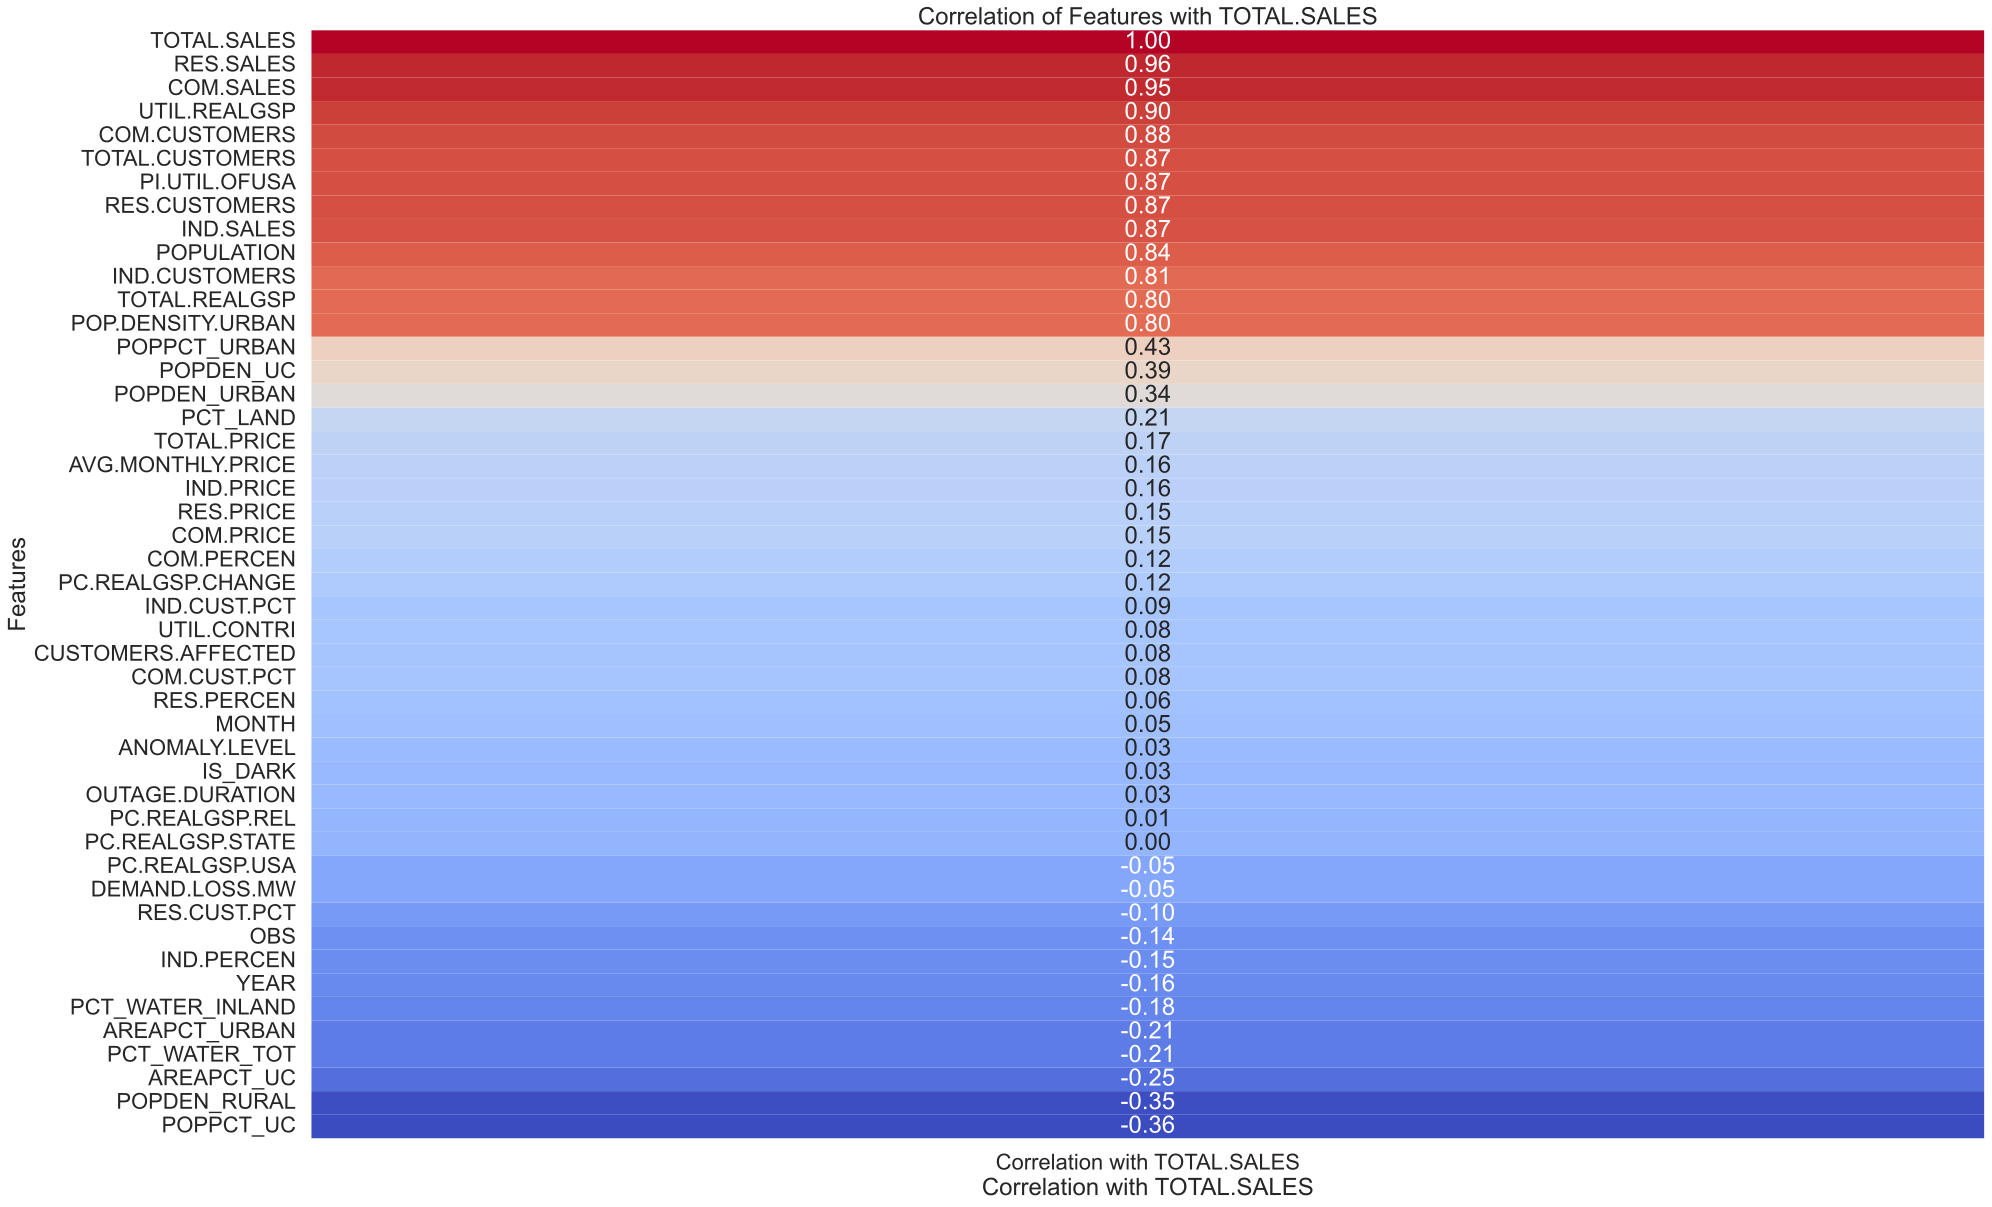

In [29]:
# Median Severity per NERC Region Group Table
outage_agg = outage.groupby('NERC.REGION')[['OUTAGE.DURATION', 
                                            'DEMAND.LOSS.MW', 
                                            'CUSTOMERS.AFFECTED']].median()

# Average Outage Duration between CLIMATE.REGION and CLIMATE.CATEGORY
outage_avg_pivot = outage.pivot_table(index='CLIMATE.REGION', columns = 'CLIMATE.CATEGORY', 
                                      values = 'OUTAGE.DURATION', aggfunc = 'mean')

# Joint Distribution Outage Duration between CLIMATE.REGION and CLIMATE.CATEGORY
outage_joint = outage.pivot_table(index='CLIMATE.REGION', columns = 'CLIMATE.CATEGORY', 
                                  values = 'OUTAGE.DURATION', aggfunc = 'count')

correlation_df = correlations_with_sales.to_frame().reset_index()
correlation_df.columns = ["Feature", "Correlation with TOTAL.SALES"]

plt.figure(figsize=(30, 20))  # Adjust size for vertical heatmap
sns.heatmap(
    correlation_df[["Correlation with TOTAL.SALES"]],  # Only show correlations
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar=False,
    yticklabels=correlation_df["Feature"],  # Display feature names vertically
)
plt.title("Correlation of Features with TOTAL.SALES")
plt.xlabel("Correlation with TOTAL.SALES")  # Label for the x-axis
plt.ylabel("Features")  # Label for the y-axis
plt.show()

features = ['CLIMATE.REGION', 'PC.REALGSP.STATE', 'YEAR', 'MONTH', 'NERC.REGION', 
            'POPULATION', 'PCT_WATER_INLAND', 'POSTAL.CODE']

## Step 3: Assessment of Missingness

Pick a column in the dataset with non-trivial missingness to analyze, and perform permutation tests to analyze the dependency of the missingness of this column on other columns.

Specifically, find at least one other column that the missingness of your selected column does depend on, and at least one other column that the missingness of your selected column does not depend on.

Tip: Make sure you know the difference between the different types of missingness before approaching that section. Many students in the past have lost credit for mistaking one type of missingness for another.

Note that some datasets may have special requirements for this section; look at the “Special Considerations” section of your chosen dataset for more details.

In [30]:
# Month Dist
outage_consumption = outage.copy()
outage_consumption['TOTAL_SALES_MISSING'] = outage_consumption['TOTAL.SALES'].isna()

month_dist = (
    outage_consumption
    .assign(total_sales_missing=outage['TOTAL.SALES'].isna())
    .pivot_table(index='MONTH', columns='total_sales_missing', aggfunc='size')
)
month_dist.columns = ['total_sales_missing = False', 'total_sales_missing = True']
month_dist = month_dist / month_dist.sum()

n_repetitions = 1_000
shuffled = outage_consumption.copy()

tvds = []
for _ in range(n_repetitions):
    shuffled['MONTH'] = np.random.permutation(shuffled['MONTH'])
    pivoted = (
        shuffled
        .pivot_table(index='MONTH', columns='TOTAL_SALES_MISSING', aggfunc='size')
    )
    pivoted = pivoted / pivoted.sum()
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)

observed_tvd = month_dist.diff(axis=1).iloc[:, -1].abs().sum() / 2

fig = px.histogram(pd.DataFrame(tvds), x=0, nbins=25, histnorm='probability', 
                   title='Empirical Distribution of the TVD')
fig.add_vline(x=observed_tvd, line_color='red', line_width=5, 
              annotation_text=f'Observed TVD = {round(observed_tvd, 2)}', 
              annotation_position='top right')
fig.update_layout(margin=dict(t=60))

p_value = (np.array(tvds) >= observed_tvd).mean()
fig.write_html('tvd-month-sales.html', include_plotlyjs='cdn')


In [31]:
# NERC Dist
outage_consumption = outage.copy()
outage_consumption['TOTAL_SALES_MISSING'] = outage_consumption['TOTAL.SALES'].isna()

nerc_category_dist = (
    outage_consumption
    .assign(total_sales_missing=outage['TOTAL.SALES'].isna())
    .pivot_table(index='NERC.REGION', columns='total_sales_missing', aggfunc='size')
)
nerc_category_dist.columns = ['total_sales_missing = False', 'total_sales_missing = True']
nerc_category_dist = nerc_category_dist / nerc_category_dist.sum()

n_repetitions = 1_000
shuffled = outage_consumption.copy()

tvds = []
for _ in range(n_repetitions):
    shuffled['NERC.REGION'] = np.random.permutation(shuffled['NERC.REGION'])
    pivoted = (
        shuffled
        .pivot_table(index='NERC.REGION', columns='TOTAL_SALES_MISSING', aggfunc='size')
    )
    pivoted = pivoted / pivoted.sum()
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)

observed_tvd = nerc_category_dist.diff(axis=1).iloc[:, -1].abs().sum() / 2

fig = px.histogram(pd.DataFrame(tvds), x=0, nbins=25, histnorm='probability', 
                   title='Empirical Distribution of the TVD')
fig.add_vline(x=observed_tvd, line_color='red', line_width=5, 
              annotation_text=f'Observed TVD = {round(observed_tvd, 2)}', 
              annotation_position='top right')
fig.update_layout(margin=dict(t=60))

p_value = (np.array(tvds) >= observed_tvd).mean()
fig.write_html('tvd-nerc-sales.html', include_plotlyjs='cdn')

## Step 4: Hypothesis Testing

Clearly state a pair of hypotheses and perform a hypothesis test or permutation test that is not related to missingness. Feel free to use one of the example questions stated in the “Example Questions and Prediction Problems” section of your dataset’s description page or pose a hypothesis test of your own.	

**Null Hypothesis (H0)**: There is no significant difference in the distribution of `DEMAND.LOSS.MW` across different levels of `TOTAL.SALES`.

**Alternative Hypothesis (H1)**: Higher levels of `TOTAL.SALES` are associated with greater `DEMAND.LOSS.MW`.

**Test Statistic**: Difference in group means between `DEMAND.LOSS.MW` of high and low levels of `TOTAL.SALES`.

**Significance Level**: Standard 0.05

In [32]:
hypothesis_outage = outage.copy()

median_sales = hypothesis_outage['TOTAL.SALES'].median()
hypothesis_outage['SALES_CATEGORY'] = np.where(hypothesis_outage['TOTAL.SALES'] >= 
                                               median_sales, 'High Sales', 'Low Sales')

mean_weights = hypothesis_outage.groupby('SALES_CATEGORY')['DEMAND.LOSS.MW'].mean()
observed_difference = mean_weights['High Sales'] - mean_weights['Low Sales']

n_repetitions = 10_000
differences = []

for _ in range(n_repetitions):
    with_shuffled = hypothesis_outage.assign(Shuffled_Weights=
                                             np.random.permutation(hypothesis_outage['DEMAND.LOSS.MW']))
    group_means = with_shuffled.groupby('SALES_CATEGORY')['Shuffled_Weights'].mean()
    difference = group_means.loc['High Sales'] - group_means.loc['Low Sales']
    differences.append(difference)

fig = px.histogram(
    pd.DataFrame(differences, columns=['Difference']), x='Difference', histnorm='probability', 
    title='Empirical Distribution of the Mean Differences in Demand \
    Loss (MW) <br> (High Total Sales - Low Total Sales)', nbins=25)
fig.add_vline(x=observed_difference, line_color='red', line_width=5, 
              annotation_text=f'Observed Difference = {round(observed_difference, 2)}', 
              annotation_position='top right')
fig.update_layout(margin=dict(t=60))

p_value = (np.array(differences) >= observed_difference).mean()

## Step 5: Framing a Prediction Problem

Identify a prediction problem. Feel free to use one of the example prediction problems stated in the “Example Questions and Prediction Problems” section of your dataset’s description page or pose a hypothesis test of your own. The prediction problem you come up with doesn’t have to be related to the question you were answering in Steps 1-4, but ideally, your entire project has some sort of coherent theme.	

Predict the electricity consumption of an area.

## Step 6: Baseline Model

Train a “baseline model” for your prediction task that uses at least two features. (For this requirement, two features means selecting at least two columns from your original dataset that you should transform). You can leave numerical features as-is, but you’ll need to take care of categorical columns using an appropriate encoding. Implement all steps (feature transforms and model training) in a single sklearn Pipeline.

Note: Both now and in Step 7: Final Model, make sure to evaluate your model’s ability to generalize to unseen data!

There is no “required” performance metric that your baseline model needs to achieve.

Imputation

In [33]:
# MAR columns
# Categorical
outage['MONTH'] = outage['MONTH'].fillna(7.0)
outage['CLIMATE.REGION'] = outage['CLIMATE.REGION'].fillna(outage['CLIMATE.REGION'].mode())
outage['CLIMATE.CATEGORY'] = outage['CLIMATE.REGION'].fillna(outage['CLIMATE.REGION'].mode())
outage['OUTAGE.START'] = outage['OUTAGE.START'].ffill()
outage['OUTAGE.RESTORATION'] = outage['OUTAGE.RESTORATION'].ffill()
outage['IS_DARK'] = np.where(outage['OUTAGE.START'].isnull(), np.nan, 
                             (outage['OUTAGE.START'].dt.time >= sunset) | 
                             (outage['OUTAGE.START'].dt.time <= sunrise))

# Numeric
def prob_impute(s):
    s = s.copy()
    num_null = s.isna().sum()
    fill_values = np.random.choice(s.dropna(), num_null)
    s[s.isna()] = fill_values
    return s


numerical = ['RES.PRICE', 'COM.PRICE', 'IND.PRICE', 'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 
             'TOTAL.SALES', 'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'POPDEN_UC', 'POPDEN_RURAL']

outage['OUTAGE.DURATION'] = (outage.groupby('CAUSE.CATEGORY')['OUTAGE.DURATION'].transform(prob_impute))
for i in numerical:
    outage[i] = (outage.groupby('CLIMATE.CATEGORY')[i].transform(prob_impute))


# MCAR columns
def quantitative_distribution(data):
    values = []
    bins = []
    hist, bin_edges = np.histogram(data.dropna())
    hist = hist / len(data.dropna())
    for i in range(len(bin_edges) - 1):
        bins.append(bin_edges[i:i + 2])
    for i in range(len(data) - data.count()):
        selected_bin = bins[np.random.choice(len(bins), p=hist)]
        values.append(np.random.uniform(selected_bin[0], selected_bin[1]))
    return np.array(values)

def impute_quantitative_column(column_data):
    missing_values = column_data.isnull()
    distribution = quantitative_distribution(column_data)
    column_data[missing_values] = distribution[:sum(missing_values)]
    return column_data

outage['ANOMALY.LEVEL'] = impute_quantitative_column(outage['ANOMALY.LEVEL'])
outage['DEMAND.LOSS.MW'] = impute_quantitative_column(outage['DEMAND.LOSS.MW'])
outage['CUSTOMERS.AFFECTED'] = impute_quantitative_column(outage['CUSTOMERS.AFFECTED'])

Baseline Model

In [34]:
features = ['CLIMATE.REGION', 'PC.REALGSP.STATE', 'YEAR', 'MONTH', 'NERC.REGION', 
            'POPULATION', 'PCT_WATER_INLAND', 'POSTAL.CODE']
target = 'TOTAL.SALES'
X = outage[features]
y = outage[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['POPULATION', 'PCT_WATER_INLAND', 'PC.REALGSP.STATE']),
        ('cat', OneHotEncoder(), ['CLIMATE.REGION', 'POSTAL.CODE', 'NERC.REGION'])
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

## Step 7: Final Model

Create a “final” model that improves upon the “baseline” model you created in Step 2. Do so by engineering at least two new features from the data, on top of any categorical encodings you performed in Baseline Model Step. (For instance, you may use a StandardScaler on a quantitative column and a QuantileTransformer transformer on a different column to get two new features.) Again, implement all steps in a single sklearn Pipeline. While deciding what features to use, you must perform a search for the best hyperparameters (e.g. tree depth) to use amongst a list(s) of options, either by using GridSearchCV or through some manual iterative method. In your notebook, state which hyperparameters you plan to tune and why before actually tuning them.

Optional: You are encouraged to try many different modeling algorithms for your final model (i.e. LinearRegression, RandomForestClassifier, Lasso, SVC, etc.) If you do this, make sure to clearly indicate in your notebook which model is your actual final model as that will be used to grade the above requirements.

Note 1: When training your model, make sure you use the same unseen and seen datasets from your baseline model. This way, the evaluation metric you get on your final model can be compared to your baseline’s on the basis of the model itself and not the dataset it was trained on. Based on which method you use for hyperparameter tuning, this may mean that you will need to use some of your training data as your validation data. If this is the case, make sure to train your final model on the whole dataset prior to evaluation.

Note 2: You will not be graded on “how much” your model improved from Step 6: Baseline Model to Step 7: Final Model. What you will be graded on is on whether or not your model improved, as well as your thoughtfulness and effort in creating features, along with the other points above.

Note 3: Don’t try to improve your model’s performance just by blindly transforming existing features into new ones. Think critically about what each transformation you’re doing actually does. For example, there’s no use in using a StandardScaler transformer if your goal is to reduce the RMSE of a linear model: as we learned in DSC 40A, and in Lecture 15, standardizing features in a regression model does not change the model’s predictions, only its coefficients!

In [39]:
outage['POP.DENSITY.URBAN'] = outage['POPULATION'] / outage['AREAPCT_URBAN']
outage['AVG.MONTHLY.PRICE'] = outage[['RES.PRICE', 'COM.PRICE', 'IND.PRICE']].mean(axis=1)

features = ['CLIMATE.REGION', 'PC.REALGSP.STATE', 'YEAR', 'MONTH', 'NERC.REGION', 
            'POPULATION', 'PCT_WATER_INLAND', 'POSTAL.CODE', 'POP.DENSITY.URBAN', 
            'AVG.MONTHLY.PRICE']
target = 'TOTAL.SALES'
X = outage[features]
y = outage[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['POPULATION', 'PCT_WATER_INLAND', 'PC.REALGSP.STATE', 
                                   'POP.DENSITY.URBAN', 'AVG.MONTHLY.PRICE']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['CLIMATE.REGION', 'POSTAL.CODE', 'NERC.REGION'])
    ], remainder='passthrough')
model = RandomForestRegressor()
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None]
}
grid_search = GridSearchCV(pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=10, 
                           error_score='raise')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_model.fit(X, y)

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2

Fitting 5 folds for each of 6 candidates, totalling 30 fits


0.993930023056006

## Step 8: Fairness Analysis

Perform a “fairness analysis” of your Final Model from the previous step. That is, try and answer the question “does my model perform worse for individuals in Group X than it does for individuals in Group Y?”, for an interesting choice of X and Y.

As always, when comparing some quantitative attribute (in this case, something like precision or RMSE) across two groups, we use a permutation test. Let’s illustrate how this works with an example. Let’s suppose we have a sample voter dataset with columns 'Name', 'Age', and 'Voted', among others. We build a classifier that predicts whether someone voted (1) or didn’t (0).

Here, we’ll say our two groups are
- “young people”, people younger than 40
- “old people”, people older than 40

Note that in this example, we manually created these groups by binarizing the 'Age' column in our dataset, and that’s fine. (Remember, the Binarizer transformer with a threshold of 40 can do this for us.)

For our evaluation metric, we’ll choose precision. (In Week 10’s lectures, we’ll look at other evaluation metrics and related parity measures for classifiers; choose the one that is most appropriate to your prediction task. If you built a regression model, you cannot use classification metrics like precision or recall; instead, you must use RMSE or 
R^2.)

Now, we must perform a permutation test. Before doing so, we must clearly state a null and an alternative hypothesis.
- Null Hypothesis: Our model is fair. Its precision for young people and old people are roughly the same, and any differences are due to random chance.
- Alternative Hypothesis: Our model is unfair. Its precision for young people is lower than its precision for old people.

From here, you should be able to implement the necessary permutation test. The only other guidance we will provide you with is that you should not be modifying your model to produce different results when computing test statistics; use only your final fitted model from Final Model Step.